gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
stroke
0    0.950211
1    0.049789
Name: proportion, dtype: float64
Before: {0: 3786, 1: 198} After: {0: 3786, 1: 3786}
Akurasi: 0.7492477432296891
ROC AUC: 0.8439915522703274
Confusion Matrix:
 [[706 241]
 [  9  41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85       947
           1       0.15      0.82      0.25        50

    accuracy                           0.75       997
   macro avg       0.57      0.78      0.55       997
weighted avg       0.95      0.75      0.82       997



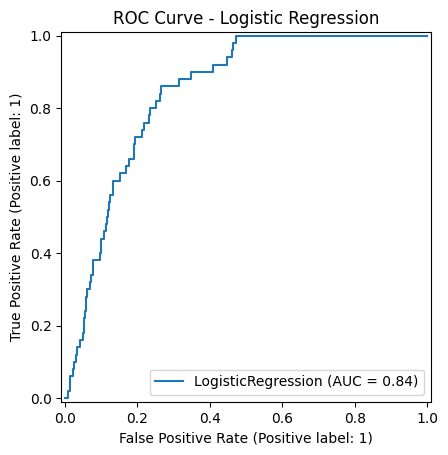

Artifacts saved to model_artifacts/


In [2]:
# COLAB: colab_training.ipynb (jalankan di Google Colab)
# 1. IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import joblib
import pickle

# 2. LOAD DATA
path = '/content/brain_stroke.csv'  # upload file melalui Colab upload atau dari Google Drive
df = pd.read_csv(path)

# 3. CLEANING
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Imputasi BMI
if 'bmi' in df.columns:
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Periksa missing
print(df.isnull().sum())

# 4. ANALISA SEDERHANA (opsional)
print(df['stroke'].value_counts(normalize=True))

# 5. PREPROCESSING
# Encode kategorikal dengan LabelEncoder (simpan encoders)
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Fitur & target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Split awal (untuk pengecekan distribusi sebelum oversampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Menangani imbalance dengan RandomOverSampler pada data training
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Before:', y_train.value_counts().to_dict(), 'After:', pd.Series(y_res).value_counts().to_dict())

# Scaling
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# 6. TRAINING (Logistic Regression)
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_res_scaled, y_res)

# 7. EVALUASI
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

print('Akurasi:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# ROC Curve plot
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()

# 8. SIMPAN ARTIFAK
import os
os.makedirs('model_artifacts', exist_ok=True)
joblib.dump(model, 'model_artifacts/model.joblib')
joblib.dump(scaler, 'model_artifacts/scaler.joblib')
with open('model_artifacts/encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print('Artifacts saved to model_artifacts/')

# 9. (Opsional) export dataset sample input schema
X.sample(5).to_csv('model_artifacts/sample_features.csv', index=False)